In [1]:
import pandas as pd

# df = pd.read_parquet("data/eurosat_rgb/initial_samples.parquet")
df = pd.read_parquet("active_labeled.parquet")
df


,filename,filepath,label
0,AnnualCrop_2216.tif,data/eurosat_rgb/0/AnnualCrop_2216.jpg,Annual Crop
1,AnnualCrop_1331.tif,data/eurosat_rgb/0/AnnualCrop_1331.jpg,Annual Crop
2,AnnualCrop_631.tif,data/eurosat_rgb/0/AnnualCrop_631.jpg,Annual Crop
3,AnnualCrop_2904.tif,data/eurosat_rgb/0/AnnualCrop_2904.jpg,Annual Crop
4,AnnualCrop_1963.tif,data/eurosat_rgb/0/AnnualCrop_1963.jpg,Annual Crop
...,...,...,...
455,None,data/eurosat_rgb/0/AnnualCrop_1077.jpg,Annual Crop
456,None,data/eurosat_rgb/8/River_1016.jpg,River
457,None,data/eurosat_rgb/2/HerbaceousVegetation_858.jpg,Herbaceous Vegetation
458,None,data/eurosat_rgb/6/PermanentCrop_890.jpg,Permanent Crop


In [2]:
df["label"].value_counts()

label
Permanent Crop           65
Herbaceous Vegetation    65
River                    65
Highway                  63
Pasture                  53
Annual Crop              47
SeaLake                  29
Industrial Buildings     29
Residential Buildings    24
Forest                   20
Name: count, dtype: int64

In [3]:
from active_vision import ActiveLearner
from fastai.vision.models.all import resnet18
from fastai.vision.all import aug_transforms

al = ActiveLearner(resnet18)

2025-01-21 21:06:52.069 | INFO     | active_vision.core:load_model:39 - Loading fastai model resnet18


In [4]:
al.load_dataset(df, filepath_col="filepath", label_col="label", 
                batch_size=16,
                image_size=64,
                batch_tfms=aug_transforms(size=64))

2025-01-21 21:06:52.868 | INFO     | active_vision.core:load_dataset:57 - Loading dataset from filepath and label
2025-01-21 21:06:52.869 | INFO     | active_vision.core:load_dataset:60 - Creating dataloaders
2025-01-21 21:06:53.252 | INFO     | active_vision.core:load_dataset:82 - Creating learner
2025-01-21 21:06:53.384 | INFO     | active_vision.core:load_dataset:89 - Done. Ready to train.


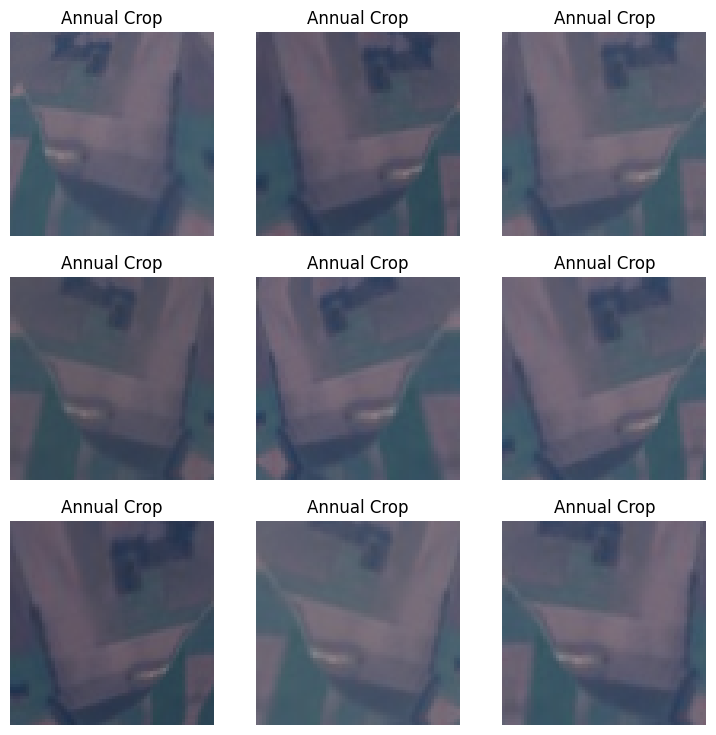

In [5]:
al.show_batch(unique=True)

In [6]:
# al.train_set

In [7]:
# al.lr_find()

2025-01-21 21:06:55.737 | INFO     | active_vision.core:train:125 - Training head for 3 epochs
2025-01-21 21:06:55.737 | INFO     | active_vision.core:train:126 - Training model end-to-end for 10 epochs
2025-01-21 21:06:55.738 | INFO     | active_vision.core:train:127 - Learning rate: 0.005 with one-cycle learning rate scheduler


epoch,train_loss,valid_loss,accuracy,time
0,3.431172,2.248201,0.293478,00:01
1,2.781328,1.949407,0.500000,00:01
2,2.437245,2.555358,0.467391,00:01


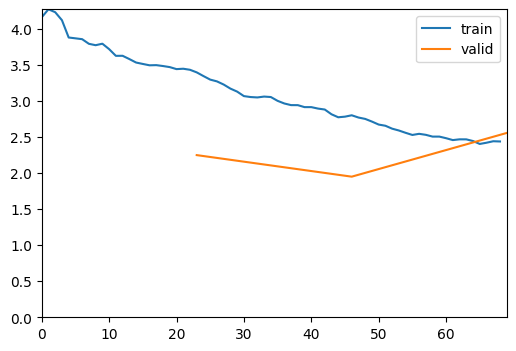

epoch,train_loss,valid_loss,accuracy,time
0,1.817674,2.300375,0.521739,00:01
1,1.624639,2.370208,0.532609,00:01
2,1.449333,2.091775,0.532609,00:01
3,1.360925,1.663842,0.576087,00:01
4,1.281859,1.476092,0.641304,00:01
5,1.079347,1.252525,0.684783,00:01
6,0.909919,1.378434,0.673913,00:01
7,0.774050,1.229807,0.641304,00:01
8,0.664991,1.205704,0.641304,00:01
9,0.610632,1.135002,0.663043,00:01


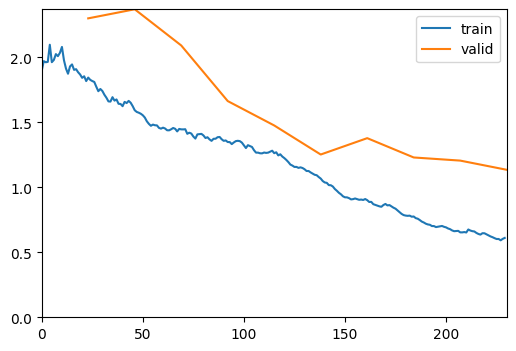

In [8]:
al.train(epochs=10, lr=5e-3, head_tuning_epochs=3)

## Evaluate the model on a *labeled* evaluation set

In [9]:
evaluation_df = pd.read_parquet("data/eurosat_rgb/evaluation_samples.parquet")
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")


2025-01-21 21:07:26.371 | INFO     | active_vision.core:evaluate:172 - Accuracy: 84.85%


0.8485185185185186

## Get the predictions from an *unlabeled* set

In [10]:
df = pd.read_parquet("data/eurosat_rgb/unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

16100

In [11]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

2025-01-21 21:07:34.907 | INFO     | active_vision.core:predict:136 - Running inference on 16100 samples


,filepath,pred_label,pred_conf,pred_raw
0,data/eurosat_rgb/0/AnnualCrop_1.jpg,Permanent Crop,0.727834,"[0.13254842162132263, 0.007131950464099646, 0.1174313947558403, 1.707596493361052e-05, 0.0003196924808435142, 0.0138753242790699, 0.7278339862823486, 0.00014608028868678957, 0.0001521964295534417, 0.0005438152002170682]"
1,data/eurosat_rgb/0/AnnualCrop_10.jpg,Annual Crop,0.988609,"[0.9886091947555542, 0.00020213527022860944, 8.267643636372668e-08, 1.4566957418082893e-07, 1.3793777497994597e-06, 0.000604054075665772, 2.6849122605199227e-06, 4.710571010946296e-05, 0.007090806495398283, 0.0034423102624714375]"
2,data/eurosat_rgb/0/AnnualCrop_100.jpg,Annual Crop,0.963529,"[0.9635289311408997, 0.00012160994083387777, 1.834243448683992e-05, 0.0035748486407101154, 7.997580723895226e-06, 0.0046944632194936275, 3.257144271628931e-05, 4.495677785598673e-05, 0.027226649224758148, 0.0007495119352824986]"
3,data/eurosat_rgb/0/AnnualCrop_1000.jpg,Annual Crop,0.978651,"[0.9786514639854431, 0.00014258615556173027, 4.31479093094822e-05, 0.0006762664415873587, 0.0002866289869416505, 0.00839290302246809, 0.00048283408978022635, 0.0014094602083787322, 0.0005149790085852146, 0.00939960591495037]"
4,data/eurosat_rgb/0/AnnualCrop_1001.jpg,Annual Crop,0.999310,"[0.9993098974227905, 2.8904212285851827e-06, 1.1380010391803808e-06, 2.0244456777618325e-07, 0.00016021858027670532, 1.39567043788702e-06, 0.0004973785835318267, 6.715145417501844e-08, 2.7997066354146227e-07, 2.6411633371026255e-05]"
...,...,...,...,...
16095,data/eurosat_rgb/9/SeaLake_993.jpg,SeaLake,0.997238,"[0.0007939359056763351, 0.0005166238988749683, 5.105288801132701e-05, 7.298718992387876e-05, 0.00022487126989290118, 0.00013049547851551324, 3.894712790497579e-06, 3.616658068494871e-05, 0.0009318380034528673, 0.9972381591796875]"
16096,data/eurosat_rgb/9/SeaLake_994.jpg,SeaLake,0.999471,"[0.00013168474833946675, 3.3084445021813735e-05, 3.739259000212769e-06, 1.0830475730472244e-05, 4.217126115690917e-05, 6.444101018132642e-05, 4.465908034489985e-07, 5.515483280760236e-06, 0.000237288826610893, 0.9994707703590393]"
16097,data/eurosat_rgb/9/SeaLake_995.jpg,SeaLake,0.999488,"[4.339396764407866e-05, 5.059662362327799e-05, 3.512768216751283e-06, 1.1163554518134333e-05, 2.9933627956779674e-05, 4.178254312137142e-05, 5.282810775497637e-07, 6.999631750659319e-06, 0.0003243408864364028, 0.9994877576828003]"
16098,data/eurosat_rgb/9/SeaLake_996.jpg,SeaLake,0.999480,"[5.317995237419382e-05, 0.00010026701784227043, 4.934444405080285e-06, 1.030437124427408e-05, 6.0807597037637606e-05, 9.531990508548915e-05, 7.420852625728003e-07, 1.5258648090821225e-05, 0.00017955443763639778, 0.9994797110557556]"


In [12]:
uncertain_df = al.sample_uncertain(pred_df, num_samples=30)
uncertain_df

2025-01-21 21:07:38.949 | INFO     | active_vision.core:sample_uncertain:194 - Getting top 30 low confidence samples


,filepath,pred_label,pred_conf,pred_raw,uncertainty_score
14507,data/eurosat_rgb/9/SeaLake_1334.jpg,Pasture,0.224623,"[0.16627448797225952, 0.01895851641893387, 0.10445916652679443, 0.09071139246225357, 0.010093404911458492, 0.22462250292301178, 0.17717121541500092, 0.018196651712059975, 0.1555914580821991, 0.03392120450735092]",0.775378
10344,data/eurosat_rgb/6/PermanentCrop_226.jpg,Pasture,0.236788,"[0.03554077446460724, 0.16790780425071716, 0.07030265033245087, 0.097772516310215, 0.008165986277163029, 0.23678794503211975, 0.1957298368215561, 0.035075295716524124, 0.132761150598526, 0.01995604671537876]",0.763212
3787,data/eurosat_rgb/2/HerbaceousVegetation_1337.jpg,Herbaceous Vegetation,0.237550,"[0.00898864958435297, 0.06165540590882301, 0.23754967749118805, 0.005837613716721535, 0.09259527176618576, 0.12727542221546173, 0.19312651455402374, 0.16215308010578156, 0.0037986075039952993, 0.10701975971460342]",0.762450
5231,data/eurosat_rgb/2/HerbaceousVegetation_827.jpg,Herbaceous Vegetation,0.240858,"[0.006641819141805172, 0.007879656739532948, 0.24085769057273865, 0.10440408438444138, 0.003621689509600401, 0.16075949370861053, 0.1875801533460617, 0.2167484611272812, 0.06659048795700073, 0.00491653848439455]",0.759142
9252,data/eurosat_rgb/5/Pasture_641.jpg,Herbaceous Vegetation,0.247967,"[0.010969651862978935, 0.24104321002960205, 0.2479672133922577, 0.005207059904932976, 0.013665290549397469, 0.2340838462114334, 0.01542443223297596, 0.005126331467181444, 0.030354803428053856, 0.19615820050239563]",0.752033
4196,data/eurosat_rgb/2/HerbaceousVegetation_1960.jpg,Forest,0.250933,"[0.006166504696011543, 0.2509332299232483, 0.15649420022964478, 0.06800518184900284, 0.015069711953401566, 0.03623872622847557, 0.014981670305132866, 0.24946720898151398, 0.15512478351593018, 0.04751874879002571]",0.749067
9194,data/eurosat_rgb/5/Pasture_546.jpg,Pasture,0.251991,"[0.027896812185645103, 0.02053375542163849, 0.15105976164340973, 0.18132531642913818, 0.009535104967653751, 0.25199124217033386, 0.07149508595466614, 0.08022723346948624, 0.20129770040512085, 0.004637971520423889]",0.748009
10295,data/eurosat_rgb/6/PermanentCrop_219.jpg,Highway,0.257039,"[0.03582058846950531, 0.21814577281475067, 0.18405628204345703, 0.25703853368759155, 0.0017523271963000298, 0.1599108725786209, 0.0832853689789772, 0.007263194769620895, 0.034684617072343826, 0.018042532727122307]",0.742961
4920,data/eurosat_rgb/2/HerbaceousVegetation_371.jpg,Herbaceous Vegetation,0.257929,"[0.0020101158879697323, 0.06874392926692963, 0.2579290568828583, 0.021007344126701355, 0.016601955518126488, 0.12460459768772125, 0.11535301059484482, 0.18370461463928223, 0.1748647391796112, 0.03518068045377731]",0.742071
9790,data/eurosat_rgb/6/PermanentCrop_1418.jpg,Highway,0.257972,"[0.07463560998439789, 0.21723443269729614, 0.08366958796977997, 0.25797227025032043, 0.010404941625893116, 0.12971660494804382, 0.21596530079841614, 0.010161429643630981, 2.352051524212584e-05, 0.00021629063121508807]",0.742028


## Label the uncertain samples

In [ ]:
al.label(uncertain_df, output_filename="uncertain")

In [ ]:
labeled_df = pd.read_parquet("uncertain.parquet")

labeled_df


In [ ]:
al.add_to_train_set(labeled_df, output_filename="active_labeled")